![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

# Destination Earth - High rate SEVIRI Level 1.5 Image Data MSG - Data Access using DEDL HDA

The Spinning Enhanced Visible and InfraRed Imager (SEVIRI) is MSG’s primary instrument and has the capacity to observe the Earth in 12 spectral channels.

[Documentation DestinE Data Lake HDA](https://hda.data.destination-earth.eu/ui/dataset/EO.EUM.DAT.MSG.HRSEVIRI)

[High Rate SEVIRI Level 1.5 Image Data - MSG - 0 degree](https://navigator.eumetsat.int/product/EO:EUM:DAT:MSG:HRSEVIRI)

## <font color='orange'> (TO SKIP UNTIL MSG collections are available on HDA) Authenticate on DESP </font>

In [ ]:
import destinelab as deauth

In [ ]:
import requests
import json
import os
from getpass import getpass

In [ ]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

##  <font color='orange'> (TO SKIP UNTIL MSG collections are available on HDA) Search MSG data  </font>

In [ ]:
response = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
    "collections": ["EO.EUM.DAT.MSG.HRSEVIRI"],
    "datetime": "2023-08-06T00:00:00Z/2023-08-07T00:00:00Z"
})


In [ ]:
from IPython.display import JSON

product = response.json()["features"][0]
JSON(product)

### <font color='orange'>  (TO SKIP UNTIL MSG collections are available on HDA) Download MSG </font>

In [ ]:
from tqdm import tqdm
import time

# Define a list of assets to download
#assets = ["Oa08_radiance.nc", "Oa06_radiance.nc", "Oa02_radiance.nc"]
assets = ["downloadLink"]

for asset in assets:
    download_url = product["assets"][asset]["href"]
    print(download_url)
    filename = asset
    print(filename)
    response = requests.get(download_url, headers=auth_headers)
    total_size = int(response.headers.get("content-length", 0))

    print(f"downloading {filename}")

    with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
        with open(filename, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)

In [ ]:
#zf=zipfile.ZipFile(filename)
#with zipfile.ZipFile(filename, 'r') as zip_ref:
#    zip_ref.extractall('.')

###  (TO DELETE WHEN MSG collections are available on HDA) DOWNLOAD WITH EUMDAC

In [1]:
pip install --upgrade --quiet eumdac

Note: you may need to restart the kernel to use updated packages.


In [2]:
import eumdac
import datetime
import shutil
import zipfile

consumer_key=<your_consumer_key>
consumer_secret=<your_consumer_secret>
credentials = (consumer_key, consumer_secret)
token = eumdac.AccessToken((consumer_key, consumer_secret))
datastore = eumdac.DataStore(token)


In [3]:
pid='MSG4-SEVI-MSG15-0100-NA-20211110081242.766000000Z-NA'
selected_product = datastore.get_product(
 product_id=pid,
 collection_id='EO:EUM:DAT:MSG:HRSEVIRI')

In [4]:
try:
 with selected_product.open() as fsrc, open(fsrc.name, mode='wb') as fdst:
   shutil.copyfileobj(fsrc, fdst)
 print(f'Download of product {selected_product} finished.')
except eumdac.product.ProductError as error:
 print(f"Error related to the product '{selected_product}' while trying to download it: '{error.msg}'")
except requests.exceptions.ConnectionError as error:
 print(f"Error related to the connection: '{error.msg}'")
except requests.exceptions.RequestException as error:
 print(f"Unexpected error: {error}")

Download of product MSG4-SEVI-MSG15-0100-NA-20211110081242.766000000Z-NA finished.


In [5]:
filename=pid+'.zip'   
zf=zipfile.ZipFile(filename)
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('.')

## satpy

The Python package satpy supports reading and loading data from many input files. 
For MSG data and the Native format, we can use the satpy reader 'seviri_l1b_native.

In [6]:
pip install --quiet satpy

Note: you may need to restart the kernel to use updated packages.


installation of others required modules

In [7]:
pip install --quiet pyspectral

Note: you may need to restart the kernel to use updated packages.


Import required libraries

In [8]:
import os
import zipfile

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.axes import Axes

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

from satpy.scene import Scene
from satpy.composites import GenericCompositor
from satpy.writers import to_image
from satpy.resample import get_area_def
from satpy import available_readers

import pyresample
import pyspectral

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

In [9]:
#file='MSG3-SEVI-MSG15-0100-NA-20240701125742.097000000Z-NA.nat'
file=pid+'.nat'

### Read and load data

We use the Scene constructor from the satpy library, a Scene object represents a single geographic region of data.
Once loaded we can list all the available bands (spectral channel) for that scene.

In [10]:
# read the file
scn = Scene(reader='seviri_l1b_native', filenames=[file])
# print available datasets
scn.available_dataset_names()

['HRV',
 'IR_016',
 'IR_039',
 'IR_087',
 'IR_097',
 'IR_108',
 'IR_120',
 'IR_134',
 'VIS006',
 'VIS008',
 'WV_062',
 'WV_073']

With the function *load()*, you can specify an individual band by name. If you then select the loaded band, you see the xarray.DataArray band object 

In [11]:
# load bands 
scn.load(['HRV','IR_108'])
scn['IR_108']

<xarray.DataArray 'reshape-b12726bd717f089114900ca7b01c0362' (y: 3712, x: 3712)>
dask.array<truediv, shape=(3712, 3712), dtype=float32, chunksize=(928, 3712), chunktype=numpy.ndarray>
Coordinates:
    acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT NaT ... NaT NaT NaT NaT NaT
    crs       object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",...
  * y         (y) float64 -5.566e+06 -5.563e+06 ... 5.566e+06 5.569e+06
  * x         (x) float64 5.566e+06 5.563e+06 5.56e+06 ... -5.566e+06 -5.569e+06
Attributes: (12/18)
    orbital_parameters:       {'projection_longitude': 0.0, 'projection_latit...
    units:                    K
    wavelength:               10.8 µm (9.8-11.8 µm)
    standard_name:            toa_brightness_temperature
    platform_name:            Meteosat-11
    sensor:                   seviri
    ...                       ...
    name:                     IR_108
    resolution:               3000.403165817
    calibration:              brightness_temperature
    modifiers:                ()
    _satpy_id:                DataID(name='IR_108', wavelength=WavelengthRang...
    ancillary_variables:      []

In [12]:
scn['IR_108'].attrs.keys()

dict_keys(['orbital_parameters', 'units', 'wavelength', 'standard_name', 'platform_name', 'sensor', 'georef_offset_corrected', 'time_parameters', 'start_time', 'end_time', 'reader', 'area', 'name', 'resolution', 'calibration', 'modifiers', '_satpy_id', 'ancillary_variables'])

In [13]:
scn['IR_108'].attrs['wavelength']

WavelengthRange(min=9.8, central=10.8, max=11.8, unit='µm')

### Visualize data combining bands

The Satpy function *available_composite_ids()*  returns a list of available composite IDs. 

In [14]:
scn = Scene(reader="seviri_l1b_native", 
             filenames=[file])

In [15]:
scn.available_composite_ids()

[DataID(name='24h_microphysics'),
 DataID(name='airmass'),
 DataID(name='ash'),
 DataID(name='cloud_phase_distinction'),
 DataID(name='cloud_phase_distinction_raw'),
 DataID(name='cloudtop'),
 DataID(name='cloudtop_daytime'),
 DataID(name='colorized_ir_clouds'),
 DataID(name='convection'),
 DataID(name='day_microphysics'),
 DataID(name='day_microphysics_winter'),
 DataID(name='dust'),
 DataID(name='fog'),
 DataID(name='green_snow'),
 DataID(name='hrv_clouds'),
 DataID(name='hrv_fog'),
 DataID(name='hrv_severe_storms'),
 DataID(name='hrv_severe_storms_masked'),
 DataID(name='ir108_3d'),
 DataID(name='ir_cloud_day'),
 DataID(name='ir_overview'),
 DataID(name='ir_sandwich'),
 DataID(name='natural_color'),
 DataID(name='natural_color_nocorr'),
 DataID(name='natural_color_raw'),
 DataID(name='natural_color_raw_with_night_ir'),
 DataID(name='natural_color_with_night_ir'),
 DataID(name='natural_color_with_night_ir_hires'),
 DataID(name='natural_enh'),
 DataID(name='natural_enh_with_night_ir')

In [16]:
composite_id = ["natural_color"]
scn.load(composite_id, upper_right_corner="NE")


In [17]:
#uncomment the following instruction will visualize the complete scene, but  it will prevent to save the notebook
#scn.show("natural_color")

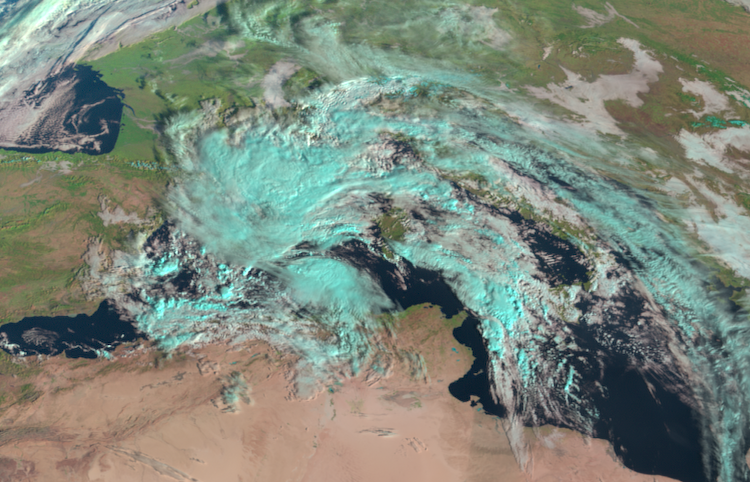

In [18]:
scn_cropped = scn.crop(ll_bbox=(-5, 31, 20, 51))
scn_cropped.show("natural_color")

In [19]:
scn = Scene(reader="seviri_l1b_native", 
             filenames=[file])

In [20]:

composite_id = ["colorized_ir_clouds"]
scn.load(composite_id, upper_right_corner="NE")

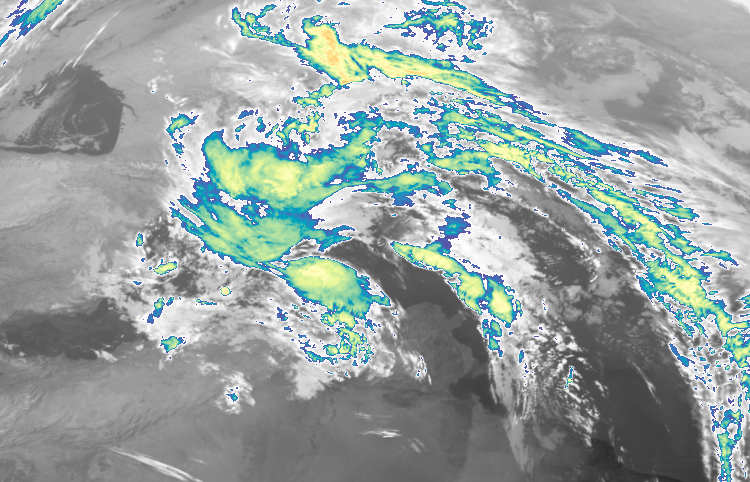

In [21]:
scn_cropped = scn.crop(ll_bbox=(-5, 31, 20, 51))
scn_cropped.show("colorized_ir_clouds")